In [215]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [216]:
SPY_2DAY = pd.read_csv('E-mini S&P 500 minute data (2 days).csv')

In [217]:
def load_data():
    df = pd.read_csv(
        'E-mini S&P 500 minute data (2 days).csv', header=1)
    cols = ["Date Time", "Close"]
    data = df[cols]
    data = data.set_axis(["timestamp", "close"], axis=1)
    return data


def deltas():
    df = load_data()
    df["log"] = np.log(df["close"].astype(float))
    df["deltas"] = df["log"].diff()
    df.dropna(inplace=True)
    final_data = df[["timestamp", "close", "deltas"]]
    #final_data = final_data.set_axis(["timestamp", "close", "deltas"], axis=1)
    return final_data

In [218]:
data = deltas()

In [219]:
data[(data['timestamp'] >= '2022-02-09') & (data['timestamp'] < '2022-02-10')]

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
941,2022-02-09 23:55:00,4568.75,0.000219
942,2022-02-09 23:56:00,4569.25,0.000109
943,2022-02-09 23:57:00,4569.75,0.000109
944,2022-02-09 23:58:00,4571.75,0.000438


In [220]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [221]:
df_testing = pd.DataFrame(np.log(data.close).diff().diff(12))
adf_check(df_testing.close.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -16.64043101577222
p-value : 1.6364587817445258e-29
Number of Lags Used : 23
Number of Observations Used : 1882
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [222]:
data

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
1915,2022-02-10 17:09:00,4491.00,-0.000612
1916,2022-02-10 17:10:00,4493.00,0.000445
1917,2022-02-10 17:11:00,4493.25,0.000056
1918,2022-02-10 17:12:00,4494.25,0.000223


In [223]:

def AR(p, df):
#Generating the lagged p terms
    df_temp = df

    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['close'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_val = pd.DataFrame(df_temp[train_size:df_temp.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    try:
        X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    except:
        return [pd.DataFrame(), pd.DataFrame(), 0, 0, float("inf")]
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,1].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    model = sm.OLS(y_train,sm.add_constant(X_train)).fit()

    #theta  = np.array([[model.params[0]]] + [[i] for i in model.params[1:]])
    theta = np.array(model.params[1:])
    #print(theta)
    intercept = model.params[0]
    df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
    # df_train_2[['Value','Predicted_Values']].plot()

    X_val = df_val.iloc[:,1:].values.reshape(-1,p)
    df_val['Predicted_Values'] = X_val.dot(theta) + intercept
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_val['close'], df_val['Predicted_Values']))
    AIC = model.aic
    BIC = model.bic

    print("The RMSE is :", RMSE,", Value of p : ",p, ", AIC is : ", AIC, ", BIC is : ", BIC)
    return [df_train_2,df_val,theta,intercept,RMSE,AIC,BIC]

In [224]:
def opt_p_rmse (df_testing, low_p, up_p):
    best_p = 0
    best_rmse = float("inf")
    for p in range(low_p, up_p):
        df_train_2,df_val,theta,intercept,RMSE = AR(p, pd.DataFrame(df_testing))
        if RMSE<best_rmse:
            best_p = p
            best_rmse = RMSE
    return best_p, best_rmse

def opt_p_aic (df_testing, low_p, up_p):
    best_p = 0
    best_aic = float("inf")
    for p in range(low_p, up_p):
        df_train_2,df_val,theta,intercept,RMSE,AIC,BIC = AR(p, pd.DataFrame(df_testing))
        if AIC<best_aic:
            best_p = p
            best_aic = AIC
    return best_p, best_aic


In [225]:
copy = df_testing.copy(deep = True)
best_p, best_aic = opt_p_aic(copy, 1, 21)
df_train_2,df_val,theta,intercept,RMSE,AIC,BIC = AR(best_p, df_testing)
df_c = pd.concat([df_train_2,df_val])
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

The RMSE is : 0.0011368740889626352 , Value of p :  1 , AIC is :  -147204.82943349064 , BIC is :  -147194.17518690613
The RMSE is : 0.001136874088962635 , Value of p :  2 , AIC is :  -125467.10480597326 , BIC is :  -125451.12540913174
The RMSE is : 0.0011368740889626356 , Value of p :  3 , AIC is :  -125654.35178261835 , BIC is :  -125633.04855260797
The RMSE is : 0.0011368740889626356 , Value of p :  4 , AIC is :  -126674.25349468144 , BIC is :  -126647.62774989166
The RMSE is : 0.001136874088962635 , Value of p :  5 , AIC is :  -125091.6416713981 , BIC is :  -125059.69473152202
The RMSE is : 0.0011368740889626354 , Value of p :  6 , AIC is :  -124935.66871266648 , BIC is :  -124898.40189870306


<ipython-input-223-3b6217848a31>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-223-3b6217848a31>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-223-3b6217848a31>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

The RMSE is : 0.0011368740889626356 , Value of p :  7 , AIC is :  -124643.85295312744 , BIC is :  -124601.26758738389
The RMSE is : 0.0011368740889626352 , Value of p :  8 , AIC is :  -125757.7029535446 , BIC is :  -125709.80035963863
The RMSE is : 0.0011368740889626347 , Value of p :  9 , AIC is :  -123274.69818119229 , BIC is :  -123221.4796840544
The RMSE is : 0.0011368740889626352 , Value of p :  10 , AIC is :  -124764.05016486823 , BIC is :  -124705.51709074409
The RMSE is : 0.0011368740889626352 , Value of p :  11 , AIC is :  -124639.00512493453 , BIC is :  -124575.15880138725
The RMSE is : 0.0011368740889626347 , Value of p :  12 , AIC is :  -123109.06520239862 , BIC is :  -123039.9069583111
The RMSE is : 0.0011368740889626356 , Value of p :  13 , AIC is :  -123645.44287641914 , BIC is :  -123570.9740419964
The RMSE is : 0.0011368740889626352 , Value of p :  14 , AIC is :  -124199.5710284865 , BIC is :  -124119.79293525798
The RMSE is : 0.0011368740889626354 , Value of p :  15 ,

<ipython-input-223-3b6217848a31>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-223-3b6217848a31>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-223-3b6217848a31>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [226]:
res

,Residuals
15,-0.000329
16,0.000110
17,0.000220
18,-0.000384
19,0.000110
...,...
1915,-0.000278
1916,0.000724
1917,-0.000278
1918,0.000723


In [227]:
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_val = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()

    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    model = sm.OLS(y_train,sm.add_constant(X_train)).fit()

    #theta  = np.array([[model.params[0]]] + [[i] for i in model.params[1:]])
    theta = np.array(model.params[1:])
    #print(theta)
    intercept = model.params[0]

    res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_val = res_val.iloc[:,1:].values.reshape(-1,q)
    res_val['Predicted_Values'] = X_val.dot(theta) + intercept
    res_val[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_val['Residuals'], res_val['Predicted_Values']))
    AIC = model.aic
    BIC = model.bic

    print("The RMSE is:",RMSE,", Value of AIC is:", AIC, ", Value of BIC is:",BIC,", Value of q:",q)
    return [res_train_2,res_val,theta,intercept,RMSE,AIC,BIC]

In [228]:
def opt_q_rmse (res, low_q, up_q):
    best_q = 0
    best_rmse = float("inf")
    for q in range(low_q, up_q):
        res_train_2,res_val,theta,intercept,RMSE = MA(q, pd.DataFrame(res))
        if RMSE<best_rmse:
            best_q = q
            best_rmse = RMSE
    return best_q, best_rmse

def opt_q_aic (df_testing, low_p, up_p):
    best_q = 0
    best_aic = float("inf")
    for q in range(low_p, up_p):
        df_train_2,df_val,theta,intercept,RMSE,AIC,BIC = MA(q, pd.DataFrame(df_testing))
        if AIC<best_aic:
            best_q = q
            best_aic = AIC
    return best_q, best_aic



<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

The RMSE is:  0.00100987702854126 , Value of AIC is:  -18920.710677506435 , Value of BIC is:  -18910.053802800645 , Value of q:  1
The RMSE is:  0.0008982979218263847 , Value of AIC is:  -19147.856428135856 , Value of BIC is:  -19131.87308652059 , Value of q:  2
The RMSE is:  0.0008628937195154593 , Value of AIC is:  -19196.607064143416 , Value of BIC is:  -19175.29857097438 , Value of q:  3
The RMSE is:  0.0008677993188931942 , Value of AIC is:  -19250.788702995826 , Value of BIC is:  -19224.156374926624 , Value of q:  4
The RMSE is:  0.0008631970644751167 , Value of AIC is:  -19253.304091490085 , Value of BIC is:  -19221.34924647451 , Value of q:  5


<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

The RMSE is:  0.0008574785620488113 , Value of AIC is:  -19260.087031987423 , Value of BIC is:  -19222.810989281734 , Value of q:  6
The RMSE is:  0.0008624112777603742 , Value of AIC is:  -19278.749633228632 , Value of BIC is:  -19236.153713393844 , Value of q:  7
The RMSE is:  0.000860465216730825 , Value of AIC is:  -19280.740224325084 , Value of BIC is:  -19232.82574922926 , Value of q:  8
The RMSE is:  0.000842467645159973 , Value of AIC is:  -19320.39492629988 , Value of BIC is:  -19267.163219120444 , Value of q:  9
The RMSE is:  0.0008389156490676375 , Value of AIC is:  -19308.362861076534 , Value of BIC is:  -19249.81524630256 , Value of q:  10


<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

The RMSE is:  0.0007795878533178063 , Value of AIC is:  -19504.028590142232 , Value of BIC is:  -19440.166393576772 , Value of q:  11
The RMSE is:  0.0007551510131465241 , Value of AIC is:  -19563.164597624673 , Value of BIC is:  -19493.98914638706 , Value of q:  12
The RMSE is:  0.0007447768476128151 , Value of AIC is:  -19590.545439599086 , Value of BIC is:  -19516.058062127267 , Value of q:  13
The RMSE is:  0.0007375595138208395 , Value of AIC is:  -19613.52794000593 , Value of BIC is:  -19533.729966058796 , Value of q:  14
The RMSE is:  0.0007330223138069912 , Value of AIC is:  -19605.516496668806 , Value of BIC is:  -19520.40925732852 , Value of q:  15


<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

The RMSE is:  0.0007364947488576267 , Value of AIC is:  -19622.374095349478 , Value of BIC is:  -19531.958923023823 , Value of q:  16
The RMSE is:  0.0007343769741611808 , Value of AIC is:  -19609.40163276338 , Value of BIC is:  -19513.679861188102 , Value of q:  17
The RMSE is:  0.0007319041533028114 , Value of AIC is:  -19599.261897835822 , Value of BIC is:  -19498.234862076984 , Value of q:  18
The RMSE is:  0.0007304746035805823 , Value of AIC is:  -19609.19046420137 , Value of BIC is:  -19502.85950065771 , Value of q:  19


<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-227-0b9e62b3156e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

The RMSE is:  0.0007323000164562288 , Value of AIC is:  -19597.392775219363 , Value of BIC is:  -19485.75922162466 , Value of q:  20
The RMSE is:  0.0007364947488576267 , Value of AIC is:  -19622.374095349478 , Value of BIC is:  -19531.958923023823 , Value of q:  16


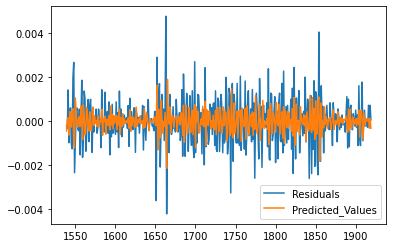

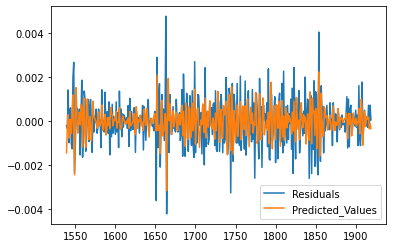

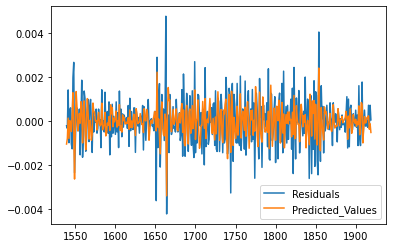

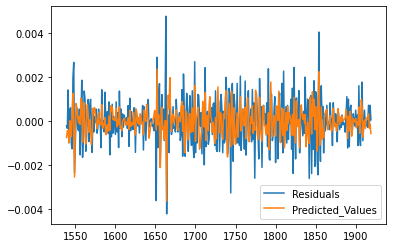

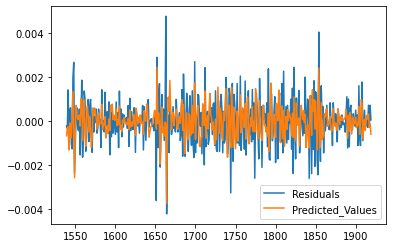

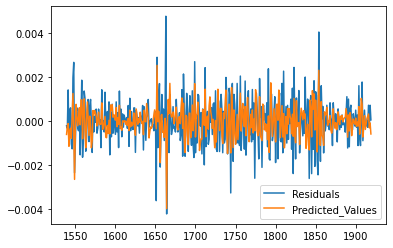

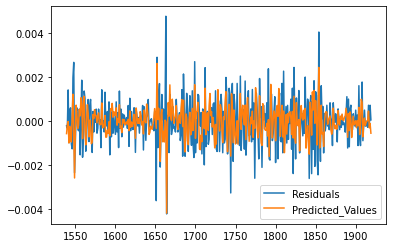

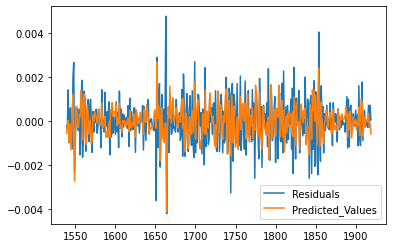

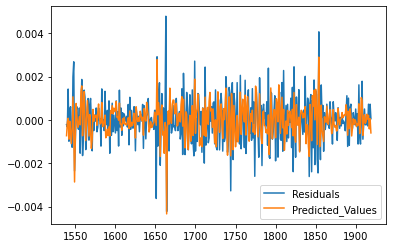

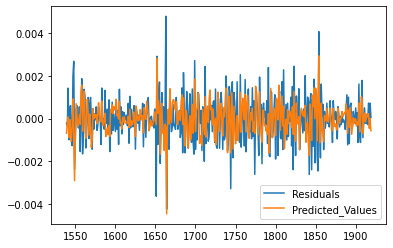

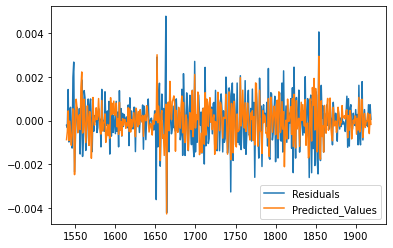

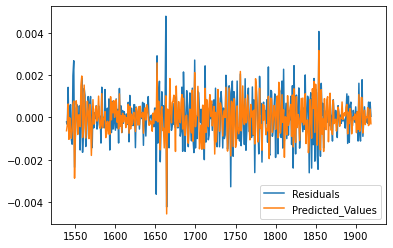

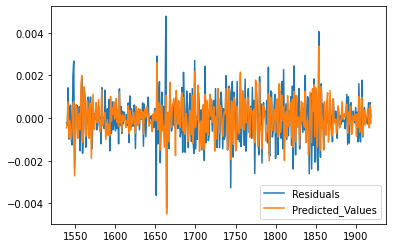

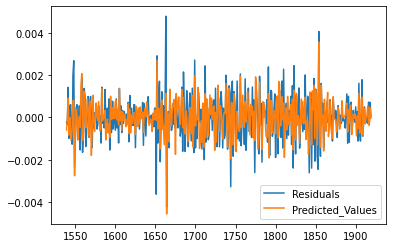

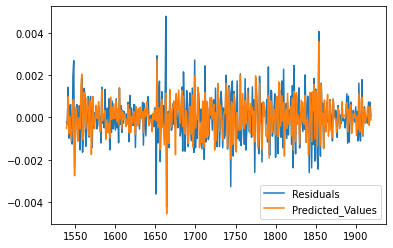

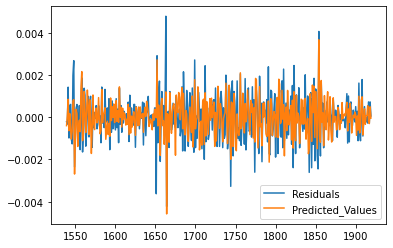

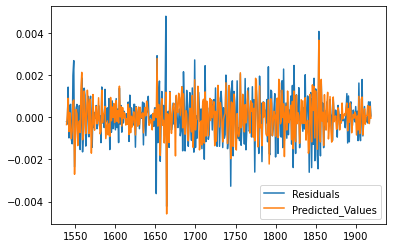

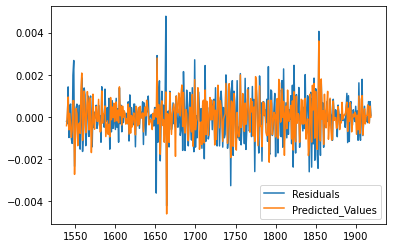

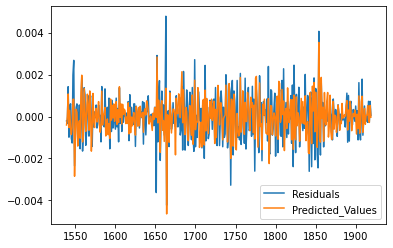

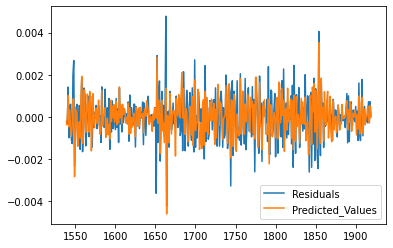

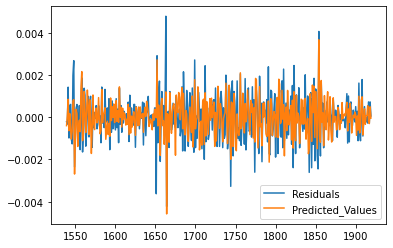

In [229]:
copy = res.copy(deep = True)
best_q, best_aic = opt_q_aic(copy, 1, 21)
res_train_2,res_val,theta,intercept,RMSE,AIC,BIC = MA(best_q, res)

(-0.003, 0.002)

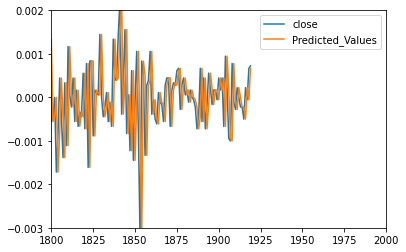

In [230]:
df_c = pd.concat([df_train_2,df_val])

import matplotlib.pyplot as plt
df_c[['close','Predicted_Values']].plot()
plt.xlim(1800, 2000)
plt.ylim(-.003, .002)

# df_c

In [231]:
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

In [232]:
res_c = pd.concat([res_train_2,res_val])


In [233]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Predicted_Values
31,0.000055,2.195510e-04,-5.488896e-04,2.744523e-04,5.482900e-05,3.294591e-04,-0.000110,-0.000165,0.000110,-0.000220,-1.807500e-08,2.743891e-04,1.097845e-04,-3.841736e-04,2.195721e-04,0.000110,-0.000329,0.000068
32,-0.000439,5.485613e-05,2.195510e-04,-5.488896e-04,2.744523e-04,5.482900e-05,0.000329,-0.000110,-0.000165,0.000110,-2.195540e-04,-1.807500e-08,2.743891e-04,1.097845e-04,-3.841736e-04,0.000220,0.000110,-0.000242
33,0.000110,-4.390448e-04,5.485613e-05,2.195510e-04,-5.488896e-04,2.744523e-04,0.000055,0.000329,-0.000110,-0.000165,1.098177e-04,-2.195540e-04,-1.807500e-08,2.743891e-04,1.097845e-04,-0.000384,0.000220,0.000184
34,0.000384,1.097574e-04,-4.390448e-04,5.485613e-05,2.195510e-04,-5.488896e-04,0.000274,0.000055,0.000329,-0.000110,-1.646587e-04,1.098177e-04,-2.195540e-04,-1.807500e-08,2.743891e-04,0.000110,-0.000384,0.000163
35,-0.000220,3.842188e-04,1.097574e-04,-4.390448e-04,5.485613e-05,2.195510e-04,-0.000549,0.000274,0.000055,0.000329,-1.098629e-04,-1.646587e-04,1.098177e-04,-2.195540e-04,-1.807500e-08,0.000274,0.000110,-0.000265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,-0.000278,1.857213e-08,-2.223393e-04,-2.228502e-04,5.009075e-04,-1.668566e-04,-0.000891,0.001781,-0.000056,-0.001113,-7.795380e-04,1.614611e-03,-1.113583e-03,2.785499e-04,-2.783112e-04,0.000501,-0.000223,0.000541
1916,0.000724,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,5.009075e-04,-0.000167,-0.000891,0.001781,-0.000056,-1.113286e-03,-7.795380e-04,1.614611e-03,-1.113583e-03,2.785499e-04,-0.000278,0.000501,-0.000199
1917,-0.000278,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,0.000501,-0.000167,-0.000891,0.001781,-5.564021e-05,-1.113286e-03,-7.795380e-04,1.614611e-03,-1.113583e-03,0.000279,-0.000278,-0.000302
1918,0.000723,-2.783174e-04,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-0.000223,0.000501,-0.000167,-0.000891,1.781260e-03,-5.564021e-05,-1.113286e-03,-7.795380e-04,1.614611e-03,-0.001114,0.000279,0.000491


In [234]:
df_c.Predicted_Values += res_c.Predicted_Values

<AxesSubplot:>

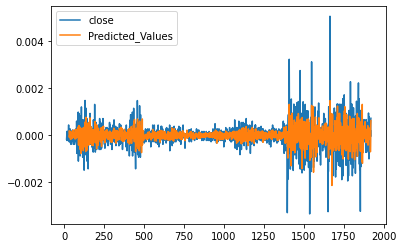

In [235]:
df_c[['close','Predicted_Values']].plot()

In [236]:
df_c.close += np.log(data.close).shift(1)
df_c.close += np.log(data.close).diff().shift(12)
df_c.Predicted_Values += np.log(data.close ).shift(1)
df_c.Predicted_Values += np.log(data.close).diff().shift(12)
df_c.close = np.exp(df_c.close)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [237]:
df_c

,close,Shifted_values_1,Predicted_Values
15,4555.00,0.000165,NaN
16,4554.25,-0.000165,NaN
17,4554.50,-0.000055,NaN
18,4554.25,0.000165,NaN
19,4554.25,-0.000220,NaN
...,...,...,...
1915,4491.00,-0.000223,4494.679692
1916,4493.00,-0.000501,4488.858475
1917,4493.25,0.000223,4493.144229
1918,4494.25,-0.000056,4493.205861


close                0
Shifted_values_1     0
Predicted_Values    16
dtype: int64

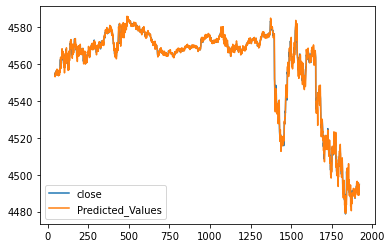

In [238]:
df_c.iloc[30:,:][['close','Predicted_Values']].plot()
np.sum(df_c.isna())